In [43]:
import pandas as pd

# Dataset location

datasetFolder="datasets/"
datasetFiles = {
    "Agricultural Land"                :"agriculturalLand.csv",
    "Debt"                             :"centralGovernmentDebt.csv",
    "CO2 Emissions"                    :"CO2Emissions.csv",
    "Account Balance"                  :"currentAccountBalance.csv",
    "Electric Consumption"             :"electricPowerConsumption.csv",
    "Energy Imports"                   :"energyImports.csv",
    "Energy Use"                       :"energyUse.csv",
    "Forest Area"                      :"forestArea.csv",
    "Fuel Exports"                     :"fuelExports.csv",
    "GDP"                              :"GDP.csv",
    "GDP Procapite"                    :"GDPProCapite.csv",
    "Life expectancy"                  :"lifeExpectancy.csv",
    "Population"                       :"Population.csv",
    "Renewable Electricity Consumption":"renewableElectricityConsumption.csv",
    "Renewable Electricity Output"     :"renewableElectricityOutput.csv",
    "Money Reserves"                   :"TotalReserves.csv"
}

# Years of interest

interestInterval = (1990, 2016)
startingYear = 1960

# Dataframe building

dfList = []
for key, value in datasetFiles.items(): 
    tempDfList = []
    dataframe = pd.read_csv(datasetFolder+value, sep=',', header=2)
    
    # Each file considered starts from 1960. Each value equal to NaN for that year
    # is put to 0. Each following NaN for that dataset will take the closest previous
    # value different from NaN.
    # e.g.: NaN NaN NaN 1 2 3 NaN NaN 4
    # Supposing that the first NaN refers to 1960,
    # this row will turn first in:  0 NaN NaN 1 2 3 NaN NaN 4
    # and then to: 0 0 0 1 2 3 3 3 4
    dataframe[str(startingYear)].fillna(0, inplace=True)
    dataframe = dataframe.fillna(method='ffill', axis=1)
    
    # For each file is created a new dataframe in which each row
    # is composed by Country Name, Value of interest of dataset (e.g. GDP), Year of that value
    # so each country appears once for each year of interest (in this case 27 times)
    for i in range (interestInterval[0], interestInterval[1]+1):
        temp_df = dataframe[["Country Name",str(i)]]
        temp_df.is_copy = False
        temp_df['Year'] = i
        # Renaming for Country Name and adding of column Year
        temp_df.columns=["Country", key, "Year"]
        tempDfList.append(temp_df)    
    # Each element of the dfList refers to a single "new" dataset.
    # Those datasets must be merged by column
    dfList.append(pd.concat(tempDfList))
    

# Merging of datasets by columns "Country" and "Year"
df = dfList[0]
for i in range(1, len(dfList)):
    df = pd.merge(df, dfList[i], on=["Country","Year"])
    

# Columns rearrangement to have Year and Country Name as first columns
cols = df.columns.tolist()
year_i = cols.index("Year")
cols.pop(year_i)
cols = ["Year"] + cols
df = df[cols]

# Conversion, when possible, to numeric values (instead of string)
df = df.apply(pd.to_numeric, errors='ignore')
df.dtypes

Year                                   int64
Country                               object
Agricultural Land                    float64
Debt                                 float64
CO2 Emissions                        float64
Account Balance                      float64
Electric Consumption                 float64
Energy Imports                       float64
Energy Use                           float64
Forest Area                          float64
Fuel Exports                         float64
GDP                                  float64
GDP Procapite                        float64
Life expectancy                      float64
Population                           float64
Renewable Electricity Consumption    float64
Renewable Electricity Output         float64
Money Reserves                       float64
dtype: object

# Supervised Learning

## Linear Regression

In [112]:
import numpy as np
from numpy.linalg import inv

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

# LINEAR REGRESSION

country = "Italy"
target_df = df.loc[df['Country']==country]

# Excluding country name
target_df = target_df.drop(df.columns[[1]], axis=1)



class LinearRegression:
    def __init__(self):
        self.beta = None
    
    def train(self, X, y):
        X = self._x_format(X)     
        # beta = (X^T * X)^(-1) * X^T * y
        self.beta = np.dot(np.dot(inv(np.dot(X.T, X)), X.T), y)
    
    def predict(self, X_input):
        x_input = self._x_format(X_input)
        # result = x_input * beta
        return np.dot(x_input, self.beta)
    
    def _x_format(self, X):
        X = np.c_[ np.ones(X.shape[0]), X]
        return X

def dataPreprocessing(df):    
    
    # Ignoring year column
    df = df.drop(df.columns[[0]], axis=1)
    
    # Scaling
    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns.values)
    
    # x_input will be the first input of our linear regression
    x_input = pd.DataFrame(df.iloc[-1])
    
    y = df.iloc[1:]
    X = df.iloc[:df.shape[0]-1]

    # data formatting as matrix
    x_input = x_input.as_matrix().T
    y = y.as_matrix()
    X = X.as_matrix()
    
    return X,y,x_input,scaler

# Prediction trial for 10 years
pred_years = 10
for i in range(1, pred_years+1):
    X,y,x_input,scal = dataPreprocessing(target_df)
    LR = LinearRegression()
    LR.train(X,y)
    # LR's beta in this case has dimension 17x16: 
    # 17 is the number of input variable (1 for bias)
    # 16 is the number of output variable
    y_hat = scal.inverse_transform(LR.predict(x_input))
    
    # Rebuilding of DataFrame, reinserting the Year at the end
    columns = list(df.columns)
    columns.remove("Country")
    columns.remove("Year")
    result = pd.DataFrame(data=y_hat)
    result.columns = columns
    result.insert(loc=0, column="Year", value=interestInterval[1]+i)

    target_df = pd.concat([target_df, result])
    
target_df.set_index('Year', inplace=True)
target_df

,Agricultural Land,Debt,CO2 Emissions,Account Balance,Electric Consumption,Energy Imports,Energy Use,Forest Area,Fuel Exports,GDP,GDP Procapite,Life expectancy,Population,Renewable Electricity Consumption,Renewable Electricity Output,Money Reserves
Year,,,,,,,,,,,,,,,,
1990,57.257489,0.000000,417550.289000,-1.643777e+10,4144.907442,82.727968,2583.888077,75900.000000,2.289327,1.177326e+12,20757.088678,76.970732,5.671924e+07,3.781463,16.376022,8.859544e+10
1991,54.585019,71.659463,423894.199000,-2.430156e+10,4224.740106,82.634121,2645.673237,76679.000000,2.304151,1.242109e+12,21884.104371,77.019512,5.675852e+07,4.669413,20.846513,7.225431e+10
1992,54.326612,77.720025,420535.227000,-2.927916e+10,4310.537968,81.736186,2627.340008,77458.000000,2.211071,1.315807e+12,23166.804063,77.419512,5.679709e+07,4.839463,20.553919,4.986159e+10
1993,54.095406,77.720025,411917.777000,7.732703e+09,4303.645312,80.938751,2611.990438,78237.000000,2.174555,1.061445e+12,18676.952579,77.721951,5.683182e+07,4.771495,20.579763,5.358981e+10
1994,53.388188,77.720025,407378.031000,1.319967e+10,4439.319253,79.870484,2578.465978,79016.000000,1.593084,1.095591e+12,19273.844170,77.921951,5.684340e+07,5.248022,21.089447,5.781713e+10
1995,52.133555,77.720025,430483.798000,2.509613e+10,4597.892598,81.512308,2799.375762,79795.000000,1.262211,1.170787e+12,20596.388576,78.170732,5.684430e+07,4.462278,17.466002,6.069011e+10
1996,52.187957,77.720025,425830.375000,3.997360e+10,4658.700157,80.960961,2796.154736,80574.000000,1.237706,1.308929e+12,23020.099940,78.521951,5.686028e+07,4.748914,19.308014,7.056644e+10
1997,52.174357,77.720025,430487.465000,3.227669e+10,4791.285246,81.145993,2834.402946,81353.000000,1.434947,1.239051e+12,21779.624367,78.824390,5.689037e+07,4.831420,18.743003,7.508649e+10
1998,52.646969,77.720025,440153.677000,2.010713e+10,4955.721944,81.728602,2912.947365,82132.000000,1.111574,1.266309e+12,22252.358086,78.975610,5.690674e+07,4.757625,18.322525,5.387970e+10


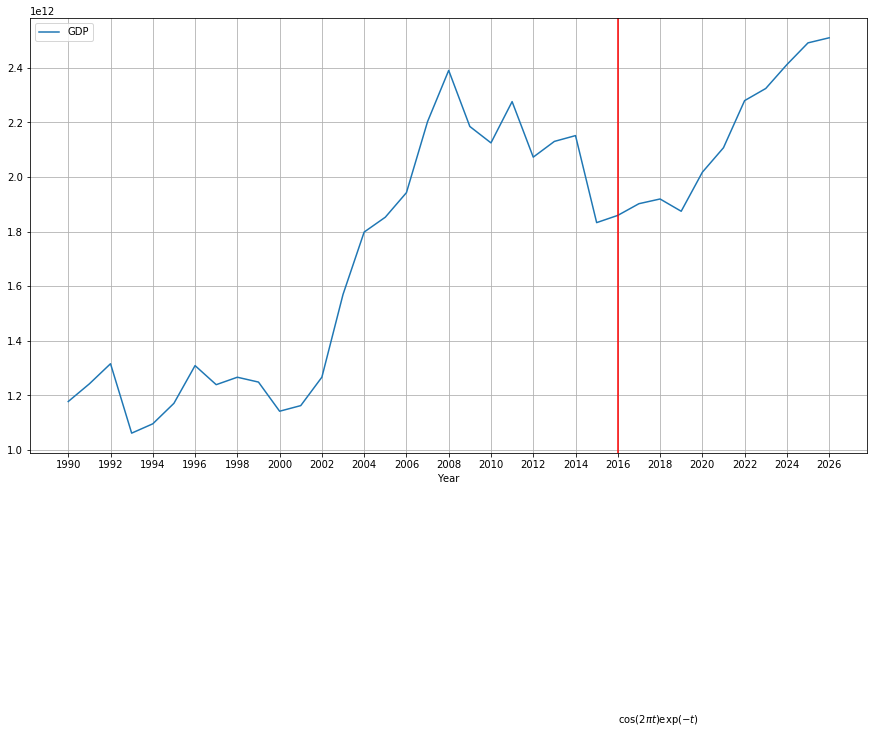

In [150]:
# Var prediction plot example

import matplotlib.pyplot as plt
tar_var = "GDP" 

single_var_df = target_df[[tar_var]]

single_var_df.plot(x=target_df.index, y=tar_var, style='-', figsize=(15,8))
plt.xticks(np.arange(min(target_df.index), max(target_df.index)+1, 2.0))
plt.grid()

# We have data until 2016

xcoord = interestInterval[1]
plt.axvline(x=xcoord, color="red")

plt.text(2016, 1., r'$\cos(2 \pi t) \exp(-t)$')

plt.show()